# Degrees That Pay You Back: A Clustering Analysis
<img src="college-salaries/salary.jpg" width="500">

## Introduction
Wondering if that Philosophy major will really help you pay the bills? Think you're set with an Engineering degree? Choosing a college major tends to be a complex decision evaluating personal interest, difficulty, and career potential. If you're curious about the potential short and long term financial implications of this _major_ decision, join me in applying a clustering analysis to explore salaries by college degree.

This project is based on the _Degrees That Pay You Back_ data referenced in the Wall Street Journal article _Ivy League's Big Edge: Starting Pay_: https://www.wsj.com/articles/SB121746658635199271. Similar further analysis could be done on the additional datasets available, examining salary potential based on the type and region of college attended. 

Let's start by loading in some relevant packages and importing the data.

In [18]:
# Load relevant packages
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)

# Read in data from 'college-salaries/degrees-that-pay-back.csv'
df <- read_csv('college-salaries/degrees-that-pay-back.csv', col_types = cols())

Take a quick look at the dataset and check out the data types of the columns.

In [2]:
head(df)
sapply(df, class)

Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,Percent change from Starting to Mid-Career Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
Accounting,"$46,000.00","$77,100.00",67.6,"$42,200.00","$56,100.00","$108,000.00","$152,000.00"
Aerospace Engineering,"$57,700.00","$101,000.00",75.0,"$64,300.00","$82,100.00","$127,000.00","$161,000.00"
Agriculture,"$42,600.00","$71,900.00",68.8,"$36,300.00","$52,100.00","$96,300.00","$150,000.00"
Anthropology,"$36,800.00","$61,500.00",67.1,"$33,800.00","$45,500.00","$89,300.00","$138,000.00"
Architecture,"$41,600.00","$76,800.00",84.6,"$50,600.00","$62,200.00","$97,000.00","$136,000.00"
Art History,"$35,800.00","$64,900.00",81.3,"$28,800.00","$42,200.00","$87,400.00","$125,000.00"


Undergraduate Major 
                                      "character" 
                           Starting Median Salary 
                                      "character" 
                         Mid-Career Median Salary 
                                      "character" 
Percent change from Starting to Mid-Career Salary 
                                        "numeric" 
                Mid-Career 10th Percentile Salary 
                                      "character" 
                Mid-Career 25th Percentile Salary 
                                      "character" 
                Mid-Career 75th Percentile Salary 
                                      "character" 
                Mid-Career 90th Percentile Salary 
                                      "character"

## Clean up the data
These column names are a bit lengthy. Let's clean them up to be a bit easier to read and reference.

In [3]:
# Remove spaces from column names for easier calling
names(df) <- make.names(names(df), unique=TRUE)
colnames(df) <- c('College.Major','Starting.Median.Salary','Mid.Career.Median.Salary','Career.Percent.Growth',
                  'Percentile.10','Percentile.25','Percentile.75','Percentile.90')

Notice also that our salary data is in currency format, which R considers a string. Let's strip those special characters using the gsub function and convert the relevant columns to numeric. While we're at it, we can also convert the Career.Percent.Growth column to a decimal value. 

In [4]:
# Convert relevant columns to numeric and strip currency symbols (all except College.Major)
majors = df['College.Major']

salaries <- df %>%
    select(-College.Major) %>%
    mutate_all(function(x) as.numeric(gsub("[\\$,]","",x))) %>%
    mutate(Career.Percent.Growth = Career.Percent.Growth/100)
               
df = bind_cols(majors,salaries)

Examine the results and verify our columns are classifed appropriately now:

In [5]:
head(df)
sapply(df,class)

College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90
Accounting,46000,77100,0.676,42200,56100,108000,152000
Aerospace Engineering,57700,101000,0.750,64300,82100,127000,161000
Agriculture,42600,71900,0.688,36300,52100,96300,150000
Anthropology,36800,61500,0.671,33800,45500,89300,138000
Architecture,41600,76800,0.846,50600,62200,97000,136000
Art History,35800,64900,0.813,28800,42200,87400,125000


College.Major   Starting.Median.Salary Mid.Career.Median.Salary 
             "character"                "numeric"                "numeric" 
   Career.Percent.Growth            Percentile.10            Percentile.25 
               "numeric"                "numeric"                "numeric" 
           Percentile.75            Percentile.90 
               "numeric"                "numeric"

## Elbow Method

Great! Now that we have a more manageable dataset, let's begin our clustering analysis using the Elbow Method to determine how many clusters we should be modeling. (For more information on finding the optimal number of clusters: https://www.r-bloggers.com/finding-optimal-number-of-clusters/ )

First, we'll select the following features to base our clusters on: Starting.Median.Salary, Mid.Career.Median.Salary,
Percentile.10, and Percentile.90. Feel free to experiment with other permutations of this or create your own features, with optional scaling.

In [6]:
k_means_data <- df %>%
    select(Starting.Median.Salary, Mid.Career.Median.Salary, Percentile.10, Percentile.90) %>%
    scale()

Run 15 k_means algorithms using 1:20 clusters and save the total within cluster sum of squares for each model. 

In [7]:
set.seed(7)
max_k <- 20
wss <- sapply(1:max_k, function(k){kmeans(k_means_data, k, nstart=50, iter.max = 15)$tot.withinss})

clusters = as.data.frame(wss)
clusters$k = 1:nrow(clusters)

Plot the total within sum of squares vs. the number of clusters to visualize the "elbow" bend for our optimal number of clusters!

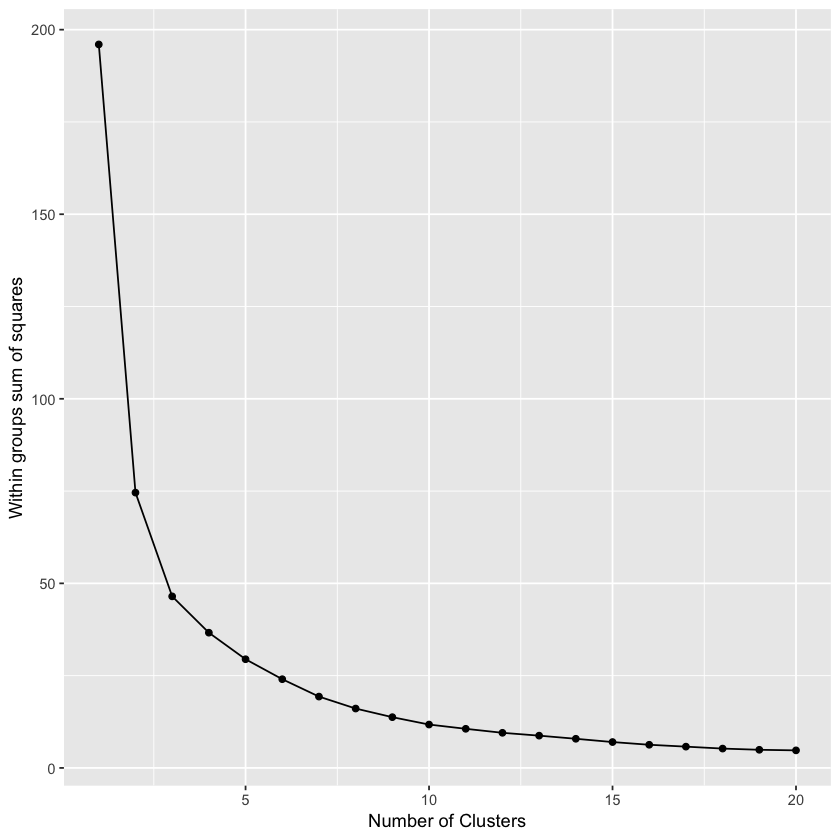

In [8]:
ggplot(clusters,aes(x=k,y=wss)) +
    geom_point() +
    geom_line() +
    xlab('Number of Clusters') +
    ylab('Within groups sum of squares')

## K-means algorithm

Looks like our optimal number of clusters might settle somewhere around 5 based on the graph above. Using this information, we can now run our k-means algorithm on the selected data and add the resulting cluster information to label our original dataframe.

In [9]:
# Set k equal to the number of clusters corresponding to the elbow location in the graph above
num_clusters <- 5

# Run the k-means algorithm with the specified number of clusters
k_means <- kmeans(k_means_data , num_clusters , iter.max = 15, nstart = 50)
df$clusters <- k_means[[1]]

## Visualize the Clusters

Now the pretty part: visualizing our results! First I'm curious about how each cluster compares in Starting vs. Mid Career Median Salaries. What do the clusters say about the relationship between Starting and Mid Career salaries?

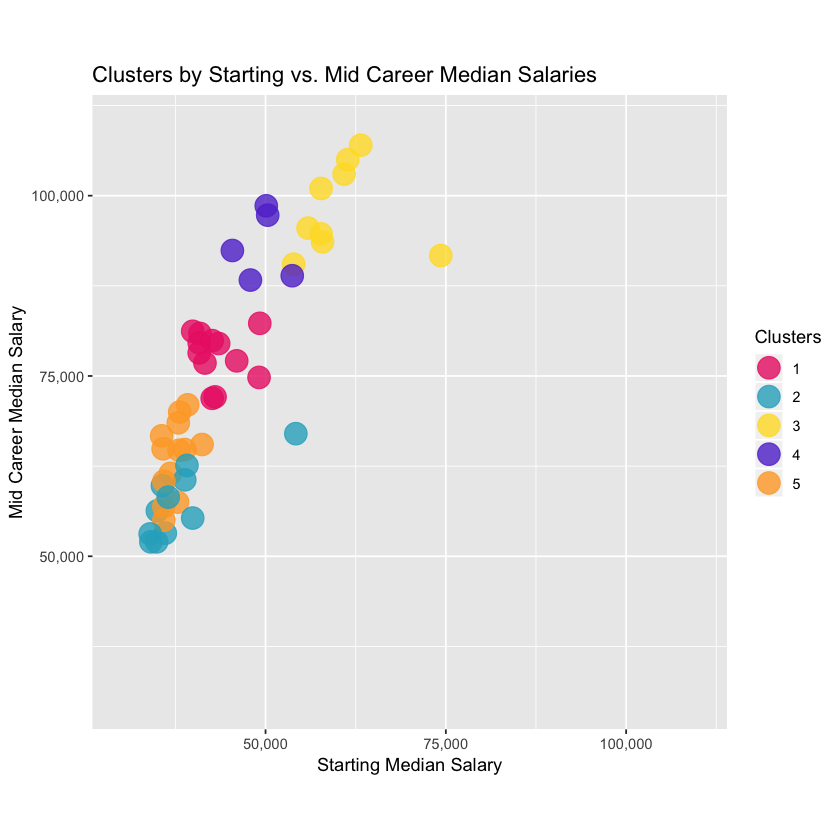

In [10]:
ggplot(df, aes(x=Starting.Median.Salary,y=Mid.Career.Median.Salary,color=factor(clusters))) +
    geom_point(alpha=4/5,size=6) +
    scale_x_continuous(labels = scales::comma, limits=c(30000,110000)) +
    scale_y_continuous(labels = scales::comma, limits=c(30000,110000)) +
    xlab('Starting Median Salary') +
    ylab('Mid Career Median Salary') +
    coord_fixed() +
    scale_color_manual(name="Clusters",values=c("#EC2C73","#29AEC7", "#FFDD30", "#623AD1", "#FFA830")) +
    ggtitle('Clusters by Starting vs. Mid Career Median Salaries')

Unsurprisingly, most of the data points are hovering in the top left corner, with a relatively linear relationship. In other words, the higher your starting salary, the higher your mid career salary. The five clusters provide a level of delineation that intuitively supports this. I do notice a bit more overlap between clusters 4 and 5, and a couple odd outliers from clusters 3 and 4 I'm curious about... perhaps this can be explained by investigating the mid career percentiles further, and exploring the actual contents of each cluster!

In order to do this, let's reshape our data to view the salaries of each college major and cluster grouped by mid career percentiles. Graphing this will help us see the range of mid career salary potential for each cluster. Let's also make sure to take advantage of ggplot's facet_wrap function to be able to easily compare each cluster side by side.

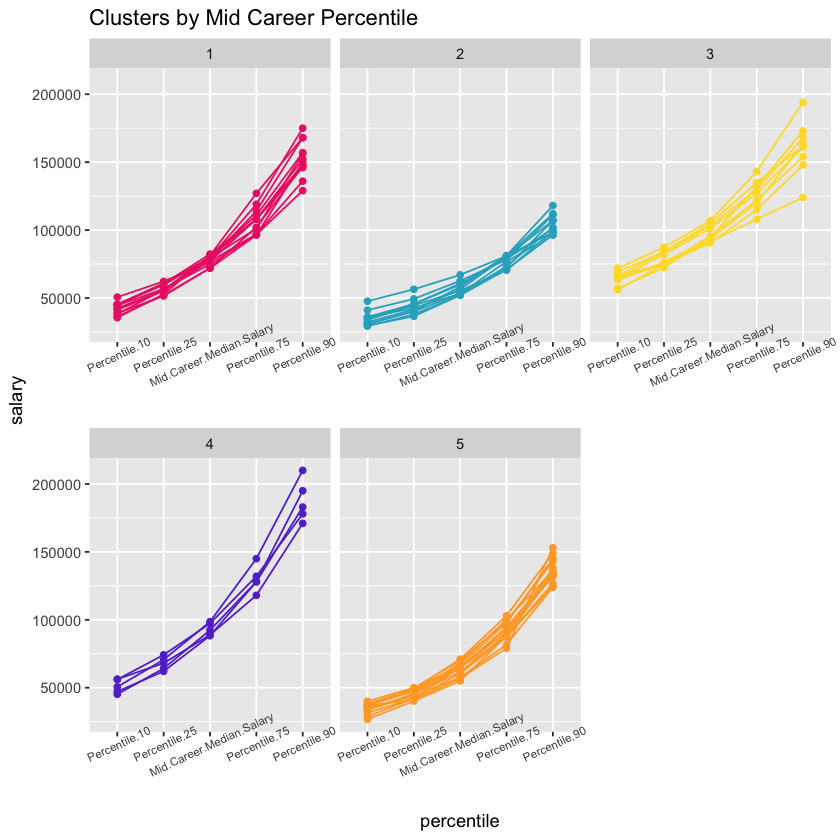

In [11]:
df_perc <- df %>%
    select(College.Major, Percentile.10, Percentile.25, Mid.Career.Median.Salary,Percentile.75, Percentile.90, clusters) %>%
    gather(key=percentile, value=salary, -c(College.Major, clusters))  

# Order the factor levels of percentile so Mid.Career.Median.Salary falls in the middle when graphing 
df_perc$percentile = factor(df_perc$percentile,levels=c('Percentile.10', 'Percentile.25', 'Mid.Career.Median.Salary','Percentile.75', 'Percentile.90'))

# Graph the range of percentiles by major and cluster side by side
ggplot(df_perc, aes(x=percentile,y=salary, group=College.Major, color=factor(clusters))) +
    geom_point() +
    geom_line() +
    facet_wrap(~ clusters, scales = "free_x") +
    ggtitle('Clusters by Mid Career Percentile') +
    scale_color_manual(values=c("#EC2C73","#29AEC7", "#FFDD30", "#623AD1", "#FFA830")) +
    theme(legend.position="none",axis.text.x = element_text(size=7, angle=25))

## A deeper dive into the clusters

The graph above definitely suggests some more interesting patterns in the range of salary potential between the clusters. Let's examine the contents of each cluster to see what stories they might be telling us about the majors.

## The Goldilocks Cluster
Accountants are known for having stable job security, but once you're in the big leagues it looks like Marketing, Philosophy, and Political Science are the winners in this cluster within the 90th percentile. These majors are fairly middle of the road in this dataset, starting off not too low and not too high in the lowest percentile, with solid growth potential.

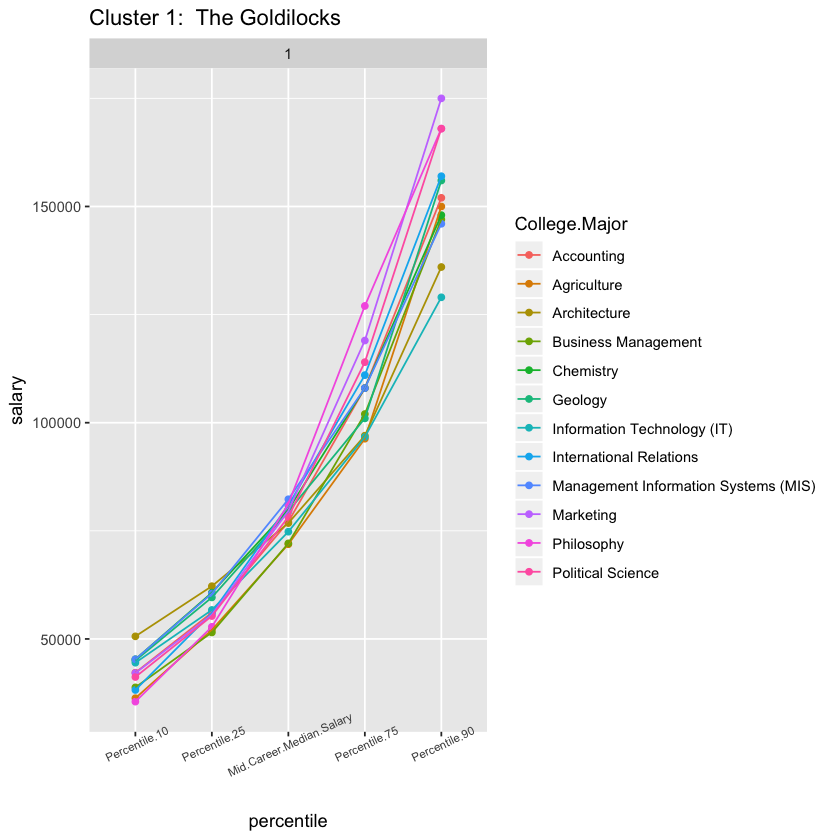

In [12]:
ggplot(df_perc[df_perc$clusters==1,], aes(x=percentile,y=salary, group=College.Major, color=College.Major, order=salary)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 1:  The Goldilocks') +
    facet_wrap(~ clusters) +
    theme(axis.text.x = element_text(size=7, angle=25)) 

## The Glass Ceiling Cluster
Nursing is the outlier culprit of cluster number 2, with a higher safety net in the lowest percentile to the median. Otherwise, this cluster represents the majors with limited growth opportunity, with Spanish and Religion sharing the least potential in the 90th percentile.

Very interesting that most of these majors leading to lower-paying jobs are women-dominated, according to this Glassdoor study: (https://www.glassdoor.com/research/app/uploads/sites/2/2017/04/FULL-STUDY-PDF-Gender-Pay-Gap2FCollege-Major.pdf) Does this imply that women are statistically choosing majors with lower pay potential, or do certain jobs pay less because women choose them...?

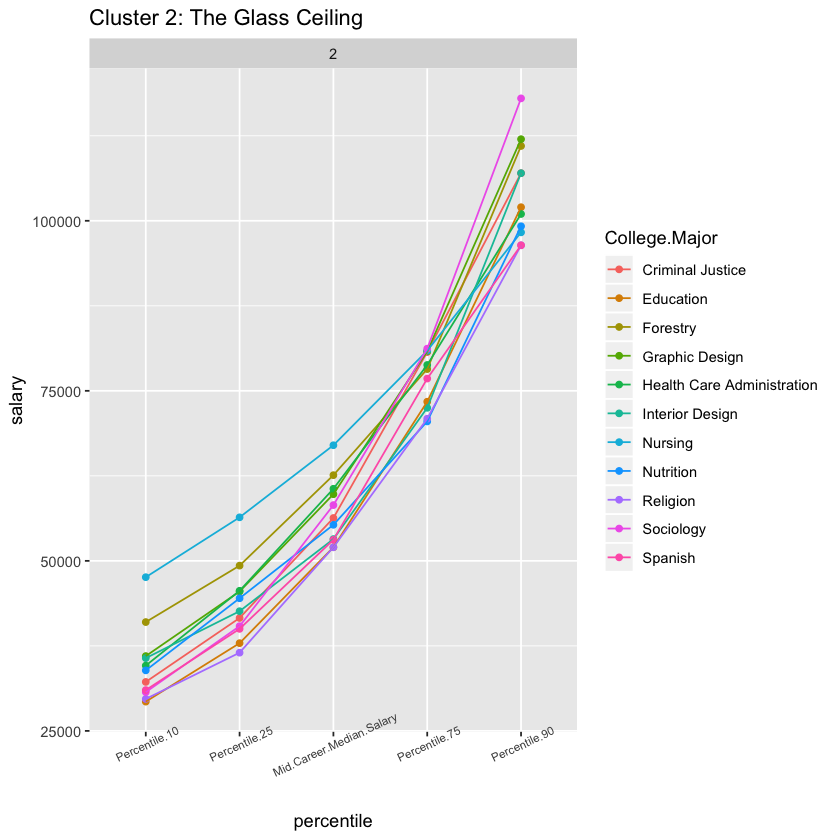

In [13]:
ggplot(df_perc[df_perc$clusters==2,], aes(x=percentile,y=salary, group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 2: The Glass Ceiling') +
    facet_wrap(~ clusters) +
    theme(axis.text.x = element_text(size=7, angle=25)) 

## The Liberal Arts
These liberal arts majors may have the riskiest position in the lowest percentile, but there is hope for those who make it! The extra dimension of mid career percentile range helps differentiate this cluster from the overlap previously observed with cluster 2. Music is our riskiest major with the lowest 10th percentile salary, while Drama wins the highest growth potential in the 90th percentile for this cluster. So don't let go of those dreams to star in the next hit Broadway musical!

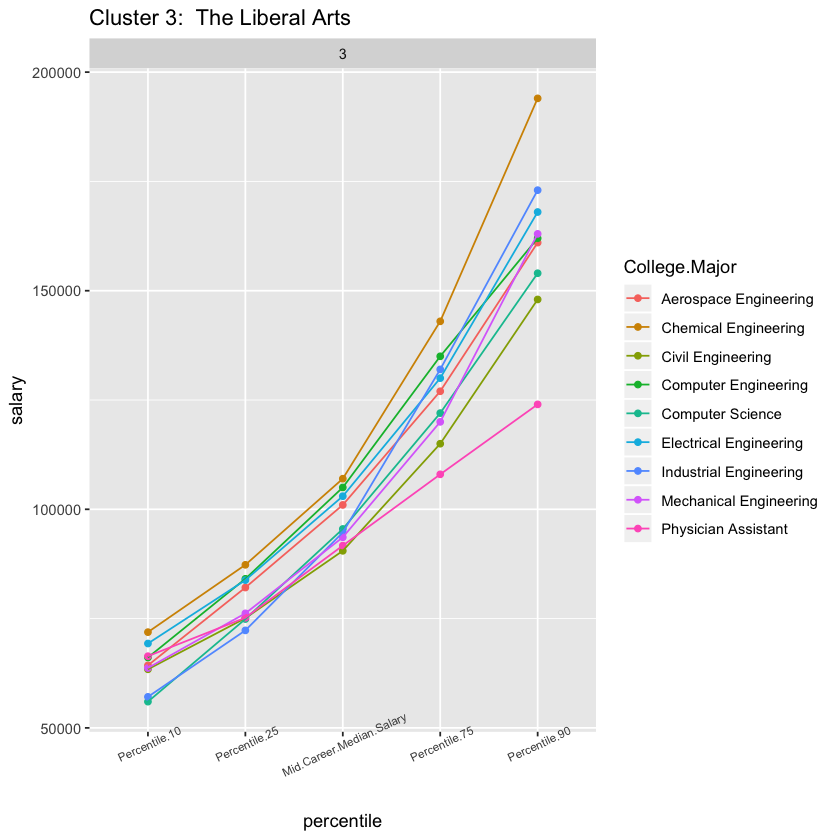

In [14]:
ggplot(df_perc[df_perc$clusters==3,], aes(x=percentile,y=salary, group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 3:  The Liberal Arts') +
    facet_wrap(~ clusters) +
    theme(axis.text.x = element_text(size=7, angle=25)) 

## The Over Achievers
If you want financial security, these are the majors to choose from. These heavy hitters represent the highest growth potential in the 90th percentile, as well as the 2nd highest cluster in 10th percentile rankings. Maybe those Freakonomics guys are on to something...

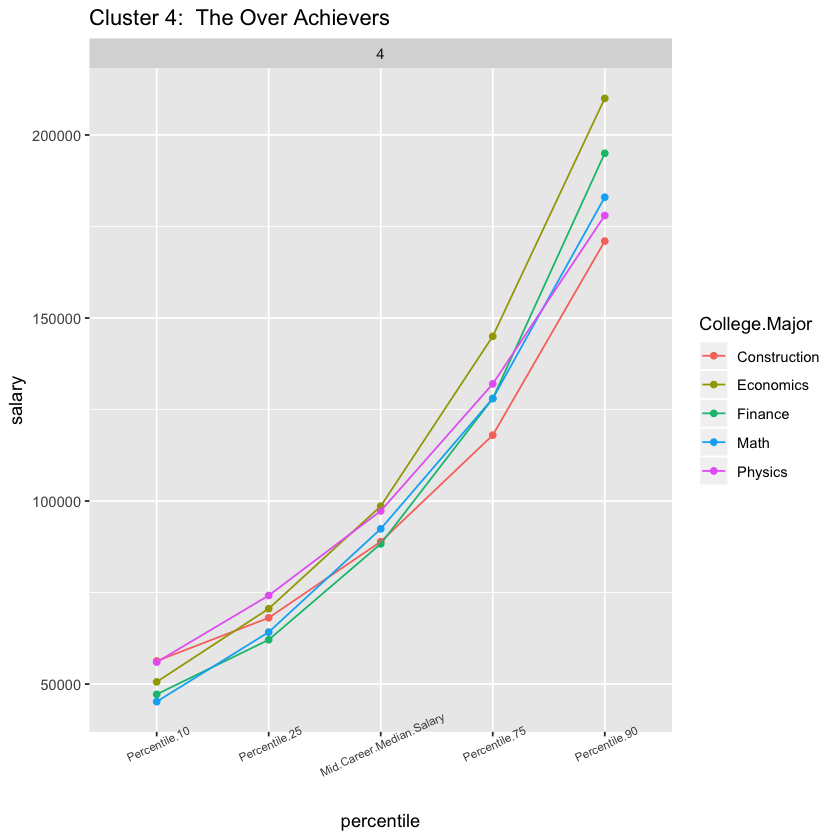

In [15]:
ggplot(df_perc[df_perc$clusters==4,], aes(x=percentile,y=salary, group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 4:  The Over Achievers') +
    facet_wrap(~ clusters) +
    theme(axis.text.x = element_text(size=7, angle=25)) 

## The Engineers
And we have our solid engineers. Besides our one previously observed outlier we can now identify as the Physician Assistant, this cluster illustrates the financially stable trajectory of the engineering majors starting with the highest 10th percentile rankings and the 2nd highest 90th percentile rankings. Keep doing what you're doing, engineers.

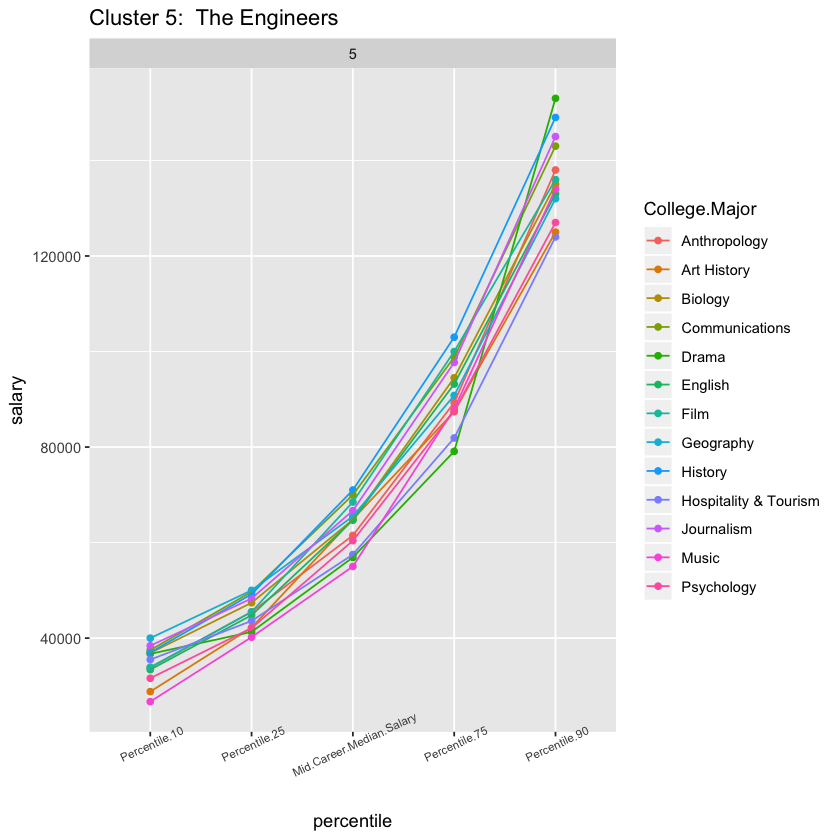

In [16]:
ggplot(df_perc[df_perc$clusters==5,], aes(x=percentile,y=salary, group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 5:  The Engineers') +
    facet_wrap(~ clusters) +
    theme(axis.text.x = element_text(size=7, angle=25)) 

## Conclusion
Thank you for joining me on this journey exploring salary projections by college major via clustering analysis! Our resulting five clusters reveal some clear patterns in starting vs. mid career salary, along with potential growth by percentiles. However, keep in mind that whether you fall into the Goldilocks, Glass Ceiling, Liberal Arts, Over Achievers, or Engineers cluster, your financial destiny will certainly be influenced by numerous other factors including the school you attend, location, your passion or talent for the subject, and of course the actual career(s) you end up in. But in the meantime, some inspiration from [xkcd](https://xkcd.com/1052/):

<img src="https://imgs.xkcd.com/comics/every_majors_terrible.png" width="500">

_Author: Jaclyn Burge (October 2018)_